In [1]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
dataset = 'C:/Users/Pro/Desktop/MachineVision/PROJECT_URGENT/Newdata/Train/Cow_train/'

In [5]:
image_size = 256
batch = 8 #number of images for each trainning
norms = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) #normalization into mean within the range from 0 to 1

In [7]:
train_ds = ImageFolder(dataset, transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*norms)])) #input data from directory to pre-process it to fit with tensor form and normalization

In [24]:
train_dl = DataLoader(train_ds, batch, shuffle=True, num_workers=3, pin_memory=True) #select random batch number of image for training section

In [10]:
def denorm(image): # return the tensor image back into original form
    return image * norms[1][0] + norms[0][0]

In [11]:
def show_images(images, nmax=256):
    fig, ax = plt.subplots(figsize=(10, 50))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=256):
    for images, _ in dl:
        show_images(images, nmax)
        break

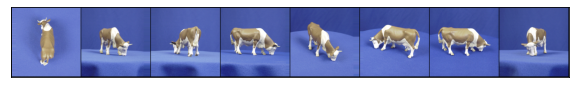

In [25]:
show_batch(train_dl)

In [4]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [5]:
device = get_default_device()
device

device(type='cpu')

In [26]:
train_dl = DeviceDataLoader(train_dl, device)

In [5]:
64*(3*4*4)

3072

In [8]:
discriminator = nn.Sequential(
    # in: 3 x 256 x 256

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 128 x 128

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 64 x 64

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 32 x 32

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 16 x 16

    nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(1024),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 1024 x 8 x 8

    nn.Conv2d(1024, 2048, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(2048),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 2048 x 4 x 4

    nn.Conv2d(2048, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [3]:
128*(1+4*4*64)

131200

In [9]:
from torchsummary import summary
summary(discriminator,(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,072
       BatchNorm2d-2         [-1, 64, 128, 128]             128
         LeakyReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4          [-1, 128, 64, 64]         131,072
       BatchNorm2d-5          [-1, 128, 64, 64]             256
         LeakyReLU-6          [-1, 128, 64, 64]               0
            Conv2d-7          [-1, 256, 32, 32]         524,288
       BatchNorm2d-8          [-1, 256, 32, 32]             512
         LeakyReLU-9          [-1, 256, 32, 32]               0
           Conv2d-10          [-1, 512, 16, 16]       2,097,152
      BatchNorm2d-11          [-1, 512, 16, 16]           1,024
        LeakyReLU-12          [-1, 512, 16, 16]               0
           Conv2d-13           [-1, 1024, 8, 8]       8,388,608
      BatchNorm2d-14           [-1, 102

In [13]:
#discriminator=torch.load('dist_cow1.pt')

In [10]:
latent = 128

In [13]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent, 2048, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(2048),
    nn.ReLU(True),
    # out: 2048 x 4 x 4

    nn.ConvTranspose2d(2048, 1024, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(1024),
    nn.ReLU(True),
    # out: 1024 x 8 x 8

    nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 16 x 16

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 32 x 32

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 64 x 64

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 128 x 128

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 256 x 256
)

In [18]:
summary(generator,(latent,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1           [-1, 2048, 4, 4]       4,194,304
       BatchNorm2d-2           [-1, 2048, 4, 4]           4,096
              ReLU-3           [-1, 2048, 4, 4]               0
   ConvTranspose2d-4           [-1, 1024, 8, 8]      33,554,432
       BatchNorm2d-5           [-1, 1024, 8, 8]           2,048
              ReLU-6           [-1, 1024, 8, 8]               0
   ConvTranspose2d-7          [-1, 512, 16, 16]       8,388,608
       BatchNorm2d-8          [-1, 512, 16, 16]           1,024
              ReLU-9          [-1, 512, 16, 16]               0
  ConvTranspose2d-10          [-1, 256, 32, 32]       2,097,152
      BatchNorm2d-11          [-1, 256, 32, 32]             512
             ReLU-12          [-1, 256, 32, 32]               0
  ConvTranspose2d-13          [-1, 128, 64, 64]         524,288
      BatchNorm2d-14          [-1, 128,

In [23]:
#generator =torch.load('model_cow1.pt')

torch.Size([8, 3, 256, 256])


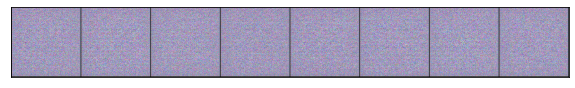

In [28]:
xb = torch.randn(batch, latent, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [29]:
generator = to_device(generator, device)

In [18]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent_space = torch.randn(batch, latent, 1, 1, device=device)
    fake_images = generator(latent_space)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [19]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent_space = torch.randn(batch, latent, 1, 1, device=device)
    fake_images = generator(latent_space)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [30]:
input_latent = torch.randn(9, latent, 1, 1, device=device) #random torch-form values are created with 9 images in latent size for training and creating new GAN images

In [31]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        #save_samples(epoch+start_idx, input_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores


In [32]:
def save_model(generator,discriminator, data_training,th):
    model_th=generator
    PATH = 'model_cow{}.pt'.format(th)
    torch.save(model_th, PATH)
    
    PATH_dist='dist_cow{}.pt'.format(th)
    dist_th=discriminator
    torch.save(dist_th,PATH_dist)

    data_th = torch.tensor(data_training)
    torch.save(data_th, 'data_training{}.pt'.format(th))

In [34]:
lr = 0.0002 # learning rate

# FIRST TIME TRAINING

In [35]:
epochs = 120
training1 = fit(epochs, lr)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/120], loss_g: 31.2424, loss_d: 0.5926, real_score: 1.0000, fake_score: 0.3525


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/120], loss_g: 32.8266, loss_d: 0.0001, real_score: 0.9999, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/120], loss_g: 32.2761, loss_d: 0.0002, real_score: 0.9998, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/120], loss_g: 27.9566, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/120], loss_g: 17.7949, loss_d: 0.1471, real_score: 1.0000, fake_score: 0.0869


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [6/120], loss_g: 10.7961, loss_d: 0.1189, real_score: 0.9960, fake_score: 0.0763


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [7/120], loss_g: 8.0613, loss_d: 0.5725, real_score: 1.0000, fake_score: 0.1544


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [8/120], loss_g: 6.8820, loss_d: 0.0565, real_score: 0.9998, fake_score: 0.0535


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [9/120], loss_g: 5.9326, loss_d: 0.0692, real_score: 0.9983, fake_score: 0.0571


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [10/120], loss_g: 9.1554, loss_d: 0.0063, real_score: 0.9971, fake_score: 0.0034


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [11/120], loss_g: 14.7393, loss_d: 1.2801, real_score: 0.9987, fake_score: 0.5472


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [12/120], loss_g: 10.1666, loss_d: 0.0512, real_score: 0.9826, fake_score: 0.0325


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [13/120], loss_g: 5.7475, loss_d: 0.0680, real_score: 0.9977, fake_score: 0.0629


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [14/120], loss_g: 1.7318, loss_d: 1.1681, real_score: 0.3875, fake_score: 0.1842


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [15/120], loss_g: 3.9528, loss_d: 0.0276, real_score: 0.9938, fake_score: 0.0208


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [16/120], loss_g: 5.4648, loss_d: 0.0399, real_score: 0.9984, fake_score: 0.0367


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [17/120], loss_g: 6.1034, loss_d: 0.2778, real_score: 0.9999, fake_score: 0.1938


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [18/120], loss_g: 16.4573, loss_d: 5.2386, real_score: 0.9999, fake_score: 0.9414


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [19/120], loss_g: 4.9368, loss_d: 0.0412, real_score: 1.0000, fake_score: 0.0393


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [20/120], loss_g: 6.0533, loss_d: 0.0779, real_score: 0.9710, fake_score: 0.0465


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [21/120], loss_g: 4.4832, loss_d: 0.0404, real_score: 0.9958, fake_score: 0.0338


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [22/120], loss_g: 6.4806, loss_d: 0.0226, real_score: 0.9967, fake_score: 0.0191


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [23/120], loss_g: 1.1240, loss_d: 0.9418, real_score: 0.4606, fake_score: 0.1473


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [24/120], loss_g: 4.2914, loss_d: 0.2055, real_score: 0.9987, fake_score: 0.1445


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [25/120], loss_g: 10.0345, loss_d: 1.4102, real_score: 0.9999, fake_score: 0.6604


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [26/120], loss_g: 5.6196, loss_d: 0.0897, real_score: 0.9248, fake_score: 0.0115


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [27/120], loss_g: 4.7437, loss_d: 0.0155, real_score: 0.9994, fake_score: 0.0147


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [28/120], loss_g: 0.5157, loss_d: 1.3116, real_score: 0.2983, fake_score: 0.0915


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [29/120], loss_g: 3.6825, loss_d: 0.3327, real_score: 0.7915, fake_score: 0.0918


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [30/120], loss_g: 4.0878, loss_d: 0.4227, real_score: 0.8004, fake_score: 0.1573


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [31/120], loss_g: 1.4702, loss_d: 0.8537, real_score: 0.4276, fake_score: 0.0042


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [32/120], loss_g: 4.7177, loss_d: 0.0662, real_score: 0.9988, fake_score: 0.0621


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [33/120], loss_g: 12.8363, loss_d: 0.2508, real_score: 0.7782, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [34/120], loss_g: 4.5953, loss_d: 13.1138, real_score: 0.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [35/120], loss_g: 6.9351, loss_d: 0.6056, real_score: 0.9837, fake_score: 0.4200


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [36/120], loss_g: 12.8594, loss_d: 4.3288, real_score: 0.9996, fake_score: 0.9819


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [37/120], loss_g: 2.2243, loss_d: 0.0924, real_score: 0.9844, fake_score: 0.0724


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [38/120], loss_g: 2.3197, loss_d: 0.1564, real_score: 0.9838, fake_score: 0.1262


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [39/120], loss_g: 2.3472, loss_d: 0.1111, real_score: 0.9793, fake_score: 0.0850


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [40/120], loss_g: 4.2868, loss_d: 0.7106, real_score: 0.9955, fake_score: 0.4582


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [41/120], loss_g: 3.4409, loss_d: 0.0266, real_score: 0.9962, fake_score: 0.0224


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [42/120], loss_g: 2.3442, loss_d: 1.3765, real_score: 0.2618, fake_score: 0.0333


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [43/120], loss_g: 0.4660, loss_d: 0.4891, real_score: 0.6346, fake_score: 0.0334


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [44/120], loss_g: 7.9296, loss_d: 0.2344, real_score: 0.9966, fake_score: 0.1878


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [45/120], loss_g: 6.2727, loss_d: 1.2493, real_score: 1.0000, fake_score: 0.6014


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [46/120], loss_g: 6.4322, loss_d: 0.4413, real_score: 0.9736, fake_score: 0.2542


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [47/120], loss_g: 2.7411, loss_d: 0.1349, real_score: 0.9780, fake_score: 0.1018


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [48/120], loss_g: 11.8311, loss_d: 1.8167, real_score: 0.9527, fake_score: 0.6979


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [49/120], loss_g: 4.8789, loss_d: 0.2700, real_score: 0.8275, fake_score: 0.0709


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [50/120], loss_g: 8.1055, loss_d: 0.1906, real_score: 0.8283, fake_score: 0.0022


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [51/120], loss_g: 7.0079, loss_d: 0.0731, real_score: 0.9838, fake_score: 0.0542


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [52/120], loss_g: 5.8080, loss_d: 0.0249, real_score: 0.9990, fake_score: 0.0232


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [53/120], loss_g: 8.7650, loss_d: 2.6068, real_score: 0.9999, fake_score: 0.8322


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [54/120], loss_g: 0.2584, loss_d: 1.7748, real_score: 0.2495, fake_score: 0.2668


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [55/120], loss_g: 3.0958, loss_d: 5.3171, real_score: 0.0050, fake_score: 0.0148


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [56/120], loss_g: 8.7424, loss_d: 0.4643, real_score: 0.9963, fake_score: 0.3165


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [57/120], loss_g: 1.7861, loss_d: 2.6549, real_score: 0.0766, fake_score: 0.0737


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [58/120], loss_g: 0.1195, loss_d: 1.9994, real_score: 0.1467, fake_score: 0.0755


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [59/120], loss_g: 5.3604, loss_d: 0.1424, real_score: 0.9879, fake_score: 0.1200


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [60/120], loss_g: 3.4003, loss_d: 0.4682, real_score: 0.8738, fake_score: 0.2692


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [61/120], loss_g: 6.5573, loss_d: 0.1106, real_score: 0.9156, fake_score: 0.0221


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [62/120], loss_g: 8.2154, loss_d: 0.1590, real_score: 0.8567, fake_score: 0.0044


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [63/120], loss_g: 14.1879, loss_d: 3.1767, real_score: 1.0000, fake_score: 0.9134


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [64/120], loss_g: 1.8065, loss_d: 0.9941, real_score: 0.4541, fake_score: 0.1828


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [65/120], loss_g: 6.4895, loss_d: 0.1502, real_score: 0.8847, fake_score: 0.0270


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [66/120], loss_g: 8.6461, loss_d: 1.2600, real_score: 0.9153, fake_score: 0.6279


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [67/120], loss_g: 7.3017, loss_d: 1.0003, real_score: 0.9985, fake_score: 0.5628


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [68/120], loss_g: 2.4690, loss_d: 0.5560, real_score: 0.6443, fake_score: 0.0856


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [69/120], loss_g: 9.5076, loss_d: 0.3799, real_score: 0.9820, fake_score: 0.2704


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [70/120], loss_g: 3.3875, loss_d: 0.2381, real_score: 0.9886, fake_score: 0.1813


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [71/120], loss_g: 5.7173, loss_d: 0.1694, real_score: 0.9955, fake_score: 0.1483


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [72/120], loss_g: 4.1592, loss_d: 0.5824, real_score: 0.5592, fake_score: 0.0010


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [73/120], loss_g: 8.6980, loss_d: 1.1483, real_score: 1.0000, fake_score: 0.5511


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [74/120], loss_g: 1.7251, loss_d: 1.1974, real_score: 0.3025, fake_score: 0.0017


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [75/120], loss_g: 13.7786, loss_d: 0.0173, real_score: 0.9838, fake_score: 0.0010


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [76/120], loss_g: 3.7142, loss_d: 0.2098, real_score: 0.9731, fake_score: 0.1468


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [77/120], loss_g: 6.9443, loss_d: 0.8934, real_score: 0.9807, fake_score: 0.4794


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [78/120], loss_g: 4.8190, loss_d: 0.9487, real_score: 1.0000, fake_score: 0.4763


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [79/120], loss_g: 2.4664, loss_d: 1.0940, real_score: 0.6678, fake_score: 0.3790


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [80/120], loss_g: 5.4624, loss_d: 0.0966, real_score: 0.9910, fake_score: 0.0824


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [81/120], loss_g: 9.2382, loss_d: 0.5402, real_score: 0.9989, fake_score: 0.3819


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [82/120], loss_g: 4.2877, loss_d: 0.5392, real_score: 0.9998, fake_score: 0.3178


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [83/120], loss_g: 8.1891, loss_d: 0.8520, real_score: 0.8282, fake_score: 0.4294


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [84/120], loss_g: 9.6324, loss_d: 5.6966, real_score: 0.0034, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [85/120], loss_g: 3.0075, loss_d: 0.1706, real_score: 0.9915, fake_score: 0.1471


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [86/120], loss_g: 2.7004, loss_d: 3.3411, real_score: 0.0363, fake_score: 0.0242


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [87/120], loss_g: 6.8058, loss_d: 0.0296, real_score: 0.9989, fake_score: 0.0276


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [88/120], loss_g: 6.3781, loss_d: 0.8163, real_score: 0.9902, fake_score: 0.4056


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [89/120], loss_g: 8.1294, loss_d: 0.2112, real_score: 0.9945, fake_score: 0.1820


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [90/120], loss_g: 6.5096, loss_d: 0.2413, real_score: 0.9969, fake_score: 0.1984


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [91/120], loss_g: 6.5832, loss_d: 0.0860, real_score: 0.9571, fake_score: 0.0411


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [92/120], loss_g: 4.8640, loss_d: 0.5838, real_score: 0.7378, fake_score: 0.2278


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [93/120], loss_g: 5.5105, loss_d: 0.0963, real_score: 0.9524, fake_score: 0.0448


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [94/120], loss_g: 0.0092, loss_d: 2.1083, real_score: 0.1234, fake_score: 0.0158


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [95/120], loss_g: 5.9302, loss_d: 1.6750, real_score: 0.9886, fake_score: 0.7705


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [96/120], loss_g: 0.2439, loss_d: 1.8933, real_score: 0.1680, fake_score: 0.0979


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [97/120], loss_g: 5.3828, loss_d: 0.0665, real_score: 0.9847, fake_score: 0.0496


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [98/120], loss_g: 6.3044, loss_d: 0.1349, real_score: 0.8934, fake_score: 0.0217


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [99/120], loss_g: 9.7940, loss_d: 1.2644, real_score: 0.9785, fake_score: 0.6651


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [100/120], loss_g: 6.3095, loss_d: 0.2570, real_score: 0.7784, fake_score: 0.0064


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [101/120], loss_g: 10.7390, loss_d: 1.0407, real_score: 0.9938, fake_score: 0.5801


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [102/120], loss_g: 3.7319, loss_d: 0.5261, real_score: 0.5998, fake_score: 0.0148


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [103/120], loss_g: 8.3470, loss_d: 8.0362, real_score: 0.0003, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [104/120], loss_g: 0.4652, loss_d: 2.6672, real_score: 0.1051, fake_score: 0.2904


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [105/120], loss_g: 5.1721, loss_d: 4.1027, real_score: 0.0166, fake_score: 0.0029


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [106/120], loss_g: 4.0799, loss_d: 0.8632, real_score: 0.7352, fake_score: 0.3748


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [107/120], loss_g: 7.1562, loss_d: 0.3528, real_score: 0.7038, fake_score: 0.0015


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [108/120], loss_g: 6.8753, loss_d: 0.4788, real_score: 0.9835, fake_score: 0.3026


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [109/120], loss_g: 4.7118, loss_d: 0.0223, real_score: 0.9978, fake_score: 0.0198


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [110/120], loss_g: 1.0833, loss_d: 2.2873, real_score: 0.1016, fake_score: 0.0004


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [111/120], loss_g: 5.5510, loss_d: 0.0760, real_score: 0.9527, fake_score: 0.0268


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [112/120], loss_g: 4.8616, loss_d: 1.1189, real_score: 0.7060, fake_score: 0.5226


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [113/120], loss_g: 4.9541, loss_d: 0.0711, real_score: 0.9873, fake_score: 0.0563


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [114/120], loss_g: 5.0355, loss_d: 0.4089, real_score: 0.8630, fake_score: 0.2258


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [115/120], loss_g: 4.6083, loss_d: 0.1342, real_score: 0.9644, fake_score: 0.0927


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [116/120], loss_g: 1.6386, loss_d: 0.5888, real_score: 0.5790, fake_score: 0.0408


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [117/120], loss_g: 6.2231, loss_d: 0.0629, real_score: 0.9463, fake_score: 0.0076


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [118/120], loss_g: 4.9581, loss_d: 0.2929, real_score: 0.9509, fake_score: 0.1989


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [119/120], loss_g: 5.8558, loss_d: 0.1088, real_score: 0.8976, fake_score: 0.0008


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [120/120], loss_g: 4.8571, loss_d: 0.1575, real_score: 0.8679, fake_score: 0.0157


In [46]:
save_model(generator,discriminator, training1,1)

# SECOND TIMES TRAINING

In [47]:
lr = 0.0002 # learning rate
epochs = 20

In [48]:
training1 = fit(epochs, lr)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/20], loss_g: 6.2530, loss_d: 0.3426, real_score: 1.0000, fake_score: 0.2801


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/20], loss_g: 11.2582, loss_d: 0.1700, real_score: 0.9999, fake_score: 0.1520


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/20], loss_g: 8.2237, loss_d: 0.1020, real_score: 0.9940, fake_score: 0.0874


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/20], loss_g: 15.7945, loss_d: 0.3475, real_score: 1.0000, fake_score: 0.2823


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/20], loss_g: 9.2048, loss_d: 0.0006, real_score: 1.0000, fake_score: 0.0006


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [6/20], loss_g: 8.5165, loss_d: 0.3401, real_score: 1.0000, fake_score: 0.2243


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [7/20], loss_g: 13.7632, loss_d: 0.6978, real_score: 0.9999, fake_score: 0.4429


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [8/20], loss_g: 4.7749, loss_d: 0.0220, real_score: 0.9990, fake_score: 0.0202


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [9/20], loss_g: 12.6624, loss_d: 0.0090, real_score: 0.9913, fake_score: 0.0003


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [10/20], loss_g: 7.6274, loss_d: 1.0654, real_score: 0.9998, fake_score: 0.4880


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [11/20], loss_g: 11.1010, loss_d: 5.4829, real_score: 0.0042, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [12/20], loss_g: 14.5146, loss_d: 0.0088, real_score: 0.9916, fake_score: 0.0004


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [13/20], loss_g: 4.2206, loss_d: 0.0106, real_score: 0.9995, fake_score: 0.0101


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [14/20], loss_g: 6.3372, loss_d: 0.1573, real_score: 0.8888, fake_score: 0.0385


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [15/20], loss_g: 8.2611, loss_d: 0.4913, real_score: 0.9952, fake_score: 0.2883


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [16/20], loss_g: 3.7325, loss_d: 0.4082, real_score: 0.6661, fake_score: 0.0019


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [17/20], loss_g: 5.4941, loss_d: 5.9672, real_score: 0.0026, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [18/20], loss_g: 1.3991, loss_d: 7.0597, real_score: 0.0009, fake_score: 0.0286


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [19/20], loss_g: 2.3478, loss_d: 5.9543, real_score: 0.0026, fake_score: 0.0062


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [20/20], loss_g: 3.8488, loss_d: 0.1798, real_score: 0.8516, fake_score: 0.0188


In [56]:
save_model(generator,discriminator, training1,2)

# THIRD TIME TRAINING (EPOCHS=60)

In [57]:
lr = 0.0002
epochs = 20

In [58]:
training3 = fit(epochs, lr)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/20], loss_g: 5.6936, loss_d: 0.0228, real_score: 0.9822, fake_score: 0.0048


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/20], loss_g: 10.1368, loss_d: 0.4681, real_score: 0.9996, fake_score: 0.3201


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/20], loss_g: 0.5547, loss_d: 0.4731, real_score: 0.6915, fake_score: 0.0932


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/20], loss_g: 8.4808, loss_d: 0.0486, real_score: 0.9729, fake_score: 0.0205


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/20], loss_g: 6.1154, loss_d: 0.1007, real_score: 0.9980, fake_score: 0.0925


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [6/20], loss_g: 17.0321, loss_d: 1.5146, real_score: 0.9985, fake_score: 0.7126


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [7/20], loss_g: 4.5890, loss_d: 0.4151, real_score: 0.6770, fake_score: 0.0245


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [8/20], loss_g: 10.5757, loss_d: 1.8540, real_score: 0.1566, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [9/20], loss_g: 8.4265, loss_d: 0.1181, real_score: 0.8900, fake_score: 0.0016


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [10/20], loss_g: 7.7493, loss_d: 0.6328, real_score: 0.9998, fake_score: 0.4353


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [11/20], loss_g: 16.6450, loss_d: 1.3531, real_score: 0.9999, fake_score: 0.6270


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [12/20], loss_g: 7.5962, loss_d: 0.0148, real_score: 0.9977, fake_score: 0.0124


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [13/20], loss_g: 5.2844, loss_d: 0.0649, real_score: 0.9986, fake_score: 0.0602


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [14/20], loss_g: 9.2188, loss_d: 9.2144, real_score: 0.0001, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [15/20], loss_g: 8.0473, loss_d: 0.4042, real_score: 0.9998, fake_score: 0.2863


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [16/20], loss_g: 5.3464, loss_d: 0.3168, real_score: 0.9997, fake_score: 0.2429


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [17/20], loss_g: 6.5037, loss_d: 1.2381, real_score: 0.8871, fake_score: 0.5503


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [18/20], loss_g: 6.7529, loss_d: 0.1393, real_score: 0.9618, fake_score: 0.0860


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [19/20], loss_g: 2.3983, loss_d: 0.1040, real_score: 0.9636, fake_score: 0.0611


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [20/20], loss_g: 2.7899, loss_d: 0.7642, real_score: 0.4708, fake_score: 0.0107


In [94]:
save_model(generator,discriminator, training3,3)

# FOURTH TIME TRAINING (EPOCHS=20)

In [95]:
epochs = 10

In [96]:
training4 = fit(epochs, lr)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/10], loss_g: 13.8679, loss_d: 0.0448, real_score: 0.9569, fake_score: 0.0008


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/10], loss_g: 11.8784, loss_d: 0.1682, real_score: 0.8452, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/10], loss_g: 5.8700, loss_d: 0.0719, real_score: 0.9998, fake_score: 0.0596


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/10], loss_g: 5.7541, loss_d: 0.0241, real_score: 0.9947, fake_score: 0.0183


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/10], loss_g: 18.6295, loss_d: 1.4753, real_score: 0.9997, fake_score: 0.7058


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [6/10], loss_g: 9.0057, loss_d: 0.2595, real_score: 0.9922, fake_score: 0.1798


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [7/10], loss_g: 10.8869, loss_d: 7.9837, real_score: 0.0003, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [8/10], loss_g: 1.8228, loss_d: 0.7464, real_score: 0.4743, fake_score: 0.0005


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [9/10], loss_g: 11.8420, loss_d: 2.1768, real_score: 0.9648, fake_score: 0.8119


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [10/10], loss_g: 5.8641, loss_d: 0.1834, real_score: 0.8436, fake_score: 0.0132


In [111]:
save_model(generator,discriminator, training4,4)

# FIFTH TIME TRAINING (EPOCHS=20)

In [112]:
training5 = fit(epochs, lr)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/10], loss_g: 8.7795, loss_d: 0.0107, real_score: 0.9966, fake_score: 0.0072


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/10], loss_g: 1.3248, loss_d: 0.4106, real_score: 0.6669, fake_score: 0.0055


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/10], loss_g: 10.4792, loss_d: 2.8869, real_score: 0.0558, fake_score: 0.0001


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/10], loss_g: 10.7811, loss_d: 2.5983, real_score: 0.9673, fake_score: 0.7400


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/10], loss_g: 7.4794, loss_d: 0.1083, real_score: 0.9110, fake_score: 0.0149


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [6/10], loss_g: 2.4699, loss_d: 4.2238, real_score: 0.0146, fake_score: 0.0005


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [7/10], loss_g: 6.0736, loss_d: 0.1983, real_score: 0.9999, fake_score: 0.1557


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [8/10], loss_g: 3.1711, loss_d: 0.0521, real_score: 0.9975, fake_score: 0.0467


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [9/10], loss_g: 6.2204, loss_d: 0.2117, real_score: 0.9036, fake_score: 0.1022


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [10/10], loss_g: 3.6057, loss_d: 0.0206, real_score: 0.9937, fake_score: 0.0141


In [127]:
save_model(generator,discriminator, training5,5)

# SIXTH TIME TRAINING (EPOCHS=10)

In [128]:
lr = 0.0002
epochs = 10

In [129]:
training6 = fit(epochs, lr)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/10], loss_g: 11.9125, loss_d: 6.0010, real_score: 0.0025, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/10], loss_g: 8.8517, loss_d: 0.4969, real_score: 0.9948, fake_score: 0.3340


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/10], loss_g: 14.4762, loss_d: 0.1681, real_score: 0.8453, fake_score: 0.0001


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/10], loss_g: 2.0981, loss_d: 2.4634, real_score: 0.0856, fake_score: 0.0056


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/10], loss_g: 11.1470, loss_d: 0.0876, real_score: 0.9349, fake_score: 0.0196


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [6/10], loss_g: 4.0490, loss_d: 0.1800, real_score: 0.8483, fake_score: 0.0153


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [7/10], loss_g: 2.4841, loss_d: 0.0768, real_score: 0.9342, fake_score: 0.0087


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [8/10], loss_g: 13.9641, loss_d: 1.8275, real_score: 0.1608, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [9/10], loss_g: 8.7106, loss_d: 0.6247, real_score: 0.8987, fake_score: 0.3187


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [10/10], loss_g: 5.2350, loss_d: 0.1182, real_score: 0.9946, fake_score: 0.1013


In [145]:
save_model(generator,discriminator, training6,6)

# SEVENTH TIME TRAINING (epochs=10)

In [146]:
training7 = fit(epochs, lr)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/10], loss_g: 5.9615, loss_d: 0.0159, real_score: 1.0000, fake_score: 0.0157


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/10], loss_g: 3.6572, loss_d: 0.2544, real_score: 0.7764, fake_score: 0.0013


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/10], loss_g: 5.4126, loss_d: 0.0034, real_score: 1.0000, fake_score: 0.0034


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/10], loss_g: 3.4981, loss_d: 0.0924, real_score: 0.9438, fake_score: 0.0334


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/10], loss_g: 0.8766, loss_d: 3.3057, real_score: 0.0367, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [6/10], loss_g: 9.9749, loss_d: 0.6824, real_score: 1.0000, fake_score: 0.4385


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [7/10], loss_g: 9.5046, loss_d: 4.8564, real_score: 0.0078, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [8/10], loss_g: 6.7409, loss_d: 6.5264, real_score: 0.0056, fake_score: 0.5631


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [9/10], loss_g: 10.1023, loss_d: 0.0989, real_score: 0.9061, fake_score: 0.0003


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [10/10], loss_g: 0.0141, loss_d: 4.7419, real_score: 0.0107, fake_score: 0.1777


In [155]:
save_model(generator,discriminator, training7,7)

# EIGHTH TIME TRAINING (epochs=10)

In [156]:
lr = 0.0002
epochs = 10

In [157]:
training8 = fit(epochs, lr)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/10], loss_g: 6.7853, loss_d: 0.2499, real_score: 0.9628, fake_score: 0.1794


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/10], loss_g: 11.5668, loss_d: 0.0072, real_score: 0.9930, fake_score: 0.0002


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/10], loss_g: 12.1678, loss_d: 0.0021, real_score: 0.9979, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/10], loss_g: 11.0012, loss_d: 0.0001, real_score: 1.0000, fake_score: 0.0001


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/10], loss_g: 6.4960, loss_d: 0.0032, real_score: 1.0000, fake_score: 0.0032


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [6/10], loss_g: 15.0255, loss_d: 0.5716, real_score: 0.9007, fake_score: 0.3522


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [7/10], loss_g: 6.5349, loss_d: 0.0072, real_score: 0.9968, fake_score: 0.0040


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [8/10], loss_g: 26.3082, loss_d: 0.9470, real_score: 1.0000, fake_score: 0.5933


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [9/10], loss_g: 11.5221, loss_d: 0.0323, real_score: 0.9685, fake_score: 0.0003


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [10/10], loss_g: 18.3110, loss_d: 2.3726, real_score: 1.0000, fake_score: 0.7370


In [167]:
save_model(generator,discriminator, training8,8)

# NINETH TIME TRAINING (epochs=5)

In [168]:
lr = 0.0002
epochs = 10

In [169]:
training9 = fit(epochs, lr)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/10], loss_g: 1.4864, loss_d: 2.1417, real_score: 0.1178, fake_score: 0.0027


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/10], loss_g: 13.9580, loss_d: 0.7187, real_score: 0.9423, fake_score: 0.4690


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/10], loss_g: 11.1942, loss_d: 0.0003, real_score: 0.9999, fake_score: 0.0002


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/10], loss_g: 2.5421, loss_d: 0.1486, real_score: 0.8678, fake_score: 0.0068


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/10], loss_g: 6.2025, loss_d: 0.2372, real_score: 0.7889, fake_score: 0.0002


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [6/10], loss_g: 3.4340, loss_d: 12.5376, real_score: 0.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [7/10], loss_g: 7.6836, loss_d: 0.0178, real_score: 0.9999, fake_score: 0.0173


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [8/10], loss_g: 0.1033, loss_d: 8.0081, real_score: 0.0003, fake_score: 0.0230


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [9/10], loss_g: 4.9477, loss_d: 0.4264, real_score: 0.9972, fake_score: 0.3335


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [10/10], loss_g: 4.9229, loss_d: 0.0737, real_score: 0.9942, fake_score: 0.0624


In [177]:
save_model(generator,discriminator, training9,9)

# TENTH TIME TRAINING (epochs=10)

In [178]:
lr = 0.0002
epochs = 20

In [179]:
training10 = fit(epochs, lr)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/20], loss_g: 7.1622, loss_d: 0.0174, real_score: 0.9840, fake_score: 0.0012


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/20], loss_g: 17.7462, loss_d: 0.0049, real_score: 0.9951, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/20], loss_g: 12.4787, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/20], loss_g: 8.8893, loss_d: 0.0001, real_score: 1.0000, fake_score: 0.0001


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/20], loss_g: 0.9203, loss_d: 1.2097, real_score: 0.3146, fake_score: 0.0512


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [6/20], loss_g: 8.3197, loss_d: 0.3098, real_score: 0.9996, fake_score: 0.2581


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [7/20], loss_g: 10.5766, loss_d: 0.0011, real_score: 0.9989, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [8/20], loss_g: 9.8677, loss_d: 0.0003, real_score: 0.9998, fake_score: 0.0001


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [9/20], loss_g: 8.7103, loss_d: 3.8709, real_score: 0.0208, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [10/20], loss_g: 5.6491, loss_d: 0.0017, real_score: 1.0000, fake_score: 0.0017


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [11/20], loss_g: 0.0521, loss_d: 4.4041, real_score: 0.0127, fake_score: 0.0338


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [12/20], loss_g: 2.6864, loss_d: 0.2296, real_score: 0.8683, fake_score: 0.0824


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [13/20], loss_g: 7.2370, loss_d: 0.0017, real_score: 0.9998, fake_score: 0.0015


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [14/20], loss_g: 15.2331, loss_d: 0.0037, real_score: 0.9963, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [15/20], loss_g: 6.5211, loss_d: 0.0279, real_score: 0.9999, fake_score: 0.0273


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [16/20], loss_g: 3.9510, loss_d: 0.1605, real_score: 0.8967, fake_score: 0.0493


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [17/20], loss_g: 9.0207, loss_d: 0.3248, real_score: 1.0000, fake_score: 0.2555


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [18/20], loss_g: 0.1490, loss_d: 2.1624, real_score: 0.1170, fake_score: 0.0166


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [19/20], loss_g: 4.8963, loss_d: 0.1783, real_score: 1.0000, fake_score: 0.1566


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [20/20], loss_g: 20.7815, loss_d: 1.7474, real_score: 0.9784, fake_score: 0.7890


In [187]:
save_model(generator,discriminator, training10,10)

# ELEVENTH TIME TRAINING (epochs=10)

In [188]:
epochs=10
training10 = fit(epochs, lr)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/10], loss_g: 8.5797, loss_d: 0.9747, real_score: 0.3773, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/10], loss_g: 6.4595, loss_d: 0.0057, real_score: 0.9983, fake_score: 0.0039


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/10], loss_g: 0.0002, loss_d: 2.8793, real_score: 0.0570, fake_score: 0.0139


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/10], loss_g: 7.1702, loss_d: 0.3185, real_score: 0.8352, fake_score: 0.1277


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/10], loss_g: 9.5506, loss_d: 0.0003, real_score: 0.9998, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [6/10], loss_g: 0.5174, loss_d: 12.8069, real_score: 0.0000, fake_score: 0.0001


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [7/10], loss_g: 3.1366, loss_d: 0.0380, real_score: 0.9896, fake_score: 0.0269


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [8/10], loss_g: 4.5462, loss_d: 0.0398, real_score: 0.9926, fake_score: 0.0316


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [9/10], loss_g: 5.6960, loss_d: 0.0337, real_score: 0.9999, fake_score: 0.0330


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [10/10], loss_g: 6.1153, loss_d: 0.0119, real_score: 0.9953, fake_score: 0.0072


In [203]:
save_model(generator,discriminator,training10,11)

In [204]:
epochs=30
training12 = fit(epochs, lr)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/30], loss_g: 12.0275, loss_d: 0.0003, real_score: 0.9998, fake_score: 0.0002


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/30], loss_g: 20.4166, loss_d: 0.0304, real_score: 0.9701, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/30], loss_g: 6.1488, loss_d: 0.3384, real_score: 0.7129, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/30], loss_g: 5.1336, loss_d: 0.0109, real_score: 0.9999, fake_score: 0.0107


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/30], loss_g: 12.4526, loss_d: 5.0678, real_score: 0.0063, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [6/30], loss_g: 18.9823, loss_d: 3.8645, real_score: 0.9978, fake_score: 0.9190


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [7/30], loss_g: 20.1585, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [8/30], loss_g: 17.4832, loss_d: 1.6321, real_score: 0.1955, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [9/30], loss_g: 17.9547, loss_d: 0.0173, real_score: 0.9829, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [10/30], loss_g: 13.9260, loss_d: 1.5907, real_score: 0.9928, fake_score: 0.6863


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [11/30], loss_g: 2.2979, loss_d: 1.5811, real_score: 0.2578, fake_score: 0.1943


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [12/30], loss_g: 5.3461, loss_d: 0.3017, real_score: 0.9939, fake_score: 0.2175


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [13/30], loss_g: 11.2497, loss_d: 0.5161, real_score: 0.9918, fake_score: 0.3307


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [14/30], loss_g: 6.3444, loss_d: 0.0113, real_score: 1.0000, fake_score: 0.0111


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [15/30], loss_g: 1.3635, loss_d: 2.1554, real_score: 0.1335, fake_score: 0.1194


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [16/30], loss_g: 15.4420, loss_d: 1.3646, real_score: 1.0000, fake_score: 0.5597


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [17/30], loss_g: 3.1988, loss_d: 2.9870, real_score: 0.0505, fake_score: 0.0015


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [18/30], loss_g: 8.0311, loss_d: 0.0049, real_score: 0.9963, fake_score: 0.0012


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [19/30], loss_g: 7.8821, loss_d: 0.0054, real_score: 0.9958, fake_score: 0.0012


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [20/30], loss_g: 23.0346, loss_d: 0.0020, real_score: 0.9980, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [21/30], loss_g: 8.4779, loss_d: 0.1446, real_score: 0.8657, fake_score: 0.0004


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [22/30], loss_g: 6.0398, loss_d: 0.2475, real_score: 0.9201, fake_score: 0.1499


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [23/30], loss_g: 11.2013, loss_d: 0.2501, real_score: 1.0000, fake_score: 0.2140


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [24/30], loss_g: 8.4957, loss_d: 0.0495, real_score: 0.9562, fake_score: 0.0047


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [25/30], loss_g: 0.2648, loss_d: 9.5349, real_score: 0.0001, fake_score: 0.0006


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [26/30], loss_g: 5.0778, loss_d: 0.2891, real_score: 0.9251, fake_score: 0.1788


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [27/30], loss_g: 5.2719, loss_d: 0.0987, real_score: 0.9990, fake_score: 0.0897


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [28/30], loss_g: 7.3754, loss_d: 7.3638, real_score: 0.0006, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [29/30], loss_g: 8.6789, loss_d: 0.0081, real_score: 0.9923, fake_score: 0.0004


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [30/30], loss_g: 5.7961, loss_d: 0.1574, real_score: 1.0000, fake_score: 0.1451


In [214]:
save_model(generator,discriminator,training12,12)

In [217]:
epochs=5
training13 = fit(epochs, lr)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/5], loss_g: 5.2827, loss_d: 0.1471, real_score: 0.8712, fake_score: 0.0091


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/5], loss_g: 12.4515, loss_d: 0.0003, real_score: 1.0000, fake_score: 0.0002


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/5], loss_g: 19.7190, loss_d: 2.1707, real_score: 1.0000, fake_score: 0.6066


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/5], loss_g: 5.5544, loss_d: 0.0602, real_score: 0.9996, fake_score: 0.0576


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/5], loss_g: 7.6413, loss_d: 0.0019, real_score: 1.0000, fake_score: 0.0019


In [228]:
save_model(generator,discriminator,training13,13)

In [229]:
epochs=5
training14 = fit(epochs, lr)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/5], loss_g: 16.0724, loss_d: 0.0546, real_score: 0.9681, fake_score: 0.0209


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/5], loss_g: 3.6201, loss_d: 0.0911, real_score: 0.9139, fake_score: 0.0011


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/5], loss_g: 27.5110, loss_d: 1.2697, real_score: 1.0000, fake_score: 0.6092


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/5], loss_g: 16.5419, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/5], loss_g: 0.0915, loss_d: 7.9047, real_score: 0.0004, fake_score: 0.0923


In [254]:
save_model(generator,discriminator,training14,14)

In [255]:
epochs=5
training15 = fit(epochs, lr)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/5], loss_g: 6.5659, loss_d: 0.0065, real_score: 1.0000, fake_score: 0.0064


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/5], loss_g: 5.8513, loss_d: 0.0131, real_score: 0.9995, fake_score: 0.0125


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/5], loss_g: 2.6337, loss_d: 0.7982, real_score: 0.4506, fake_score: 0.0010


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/5], loss_g: 16.7904, loss_d: 0.0006, real_score: 0.9997, fake_score: 0.0002


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/5], loss_g: 14.3546, loss_d: 0.0236, real_score: 0.9767, fake_score: 0.0000


In [263]:
save_model(generator,discriminator,training15,15)

In [264]:
epochs=5
training16 = fit(epochs, lr)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/5], loss_g: 15.2069, loss_d: 0.7390, real_score: 0.4776, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/5], loss_g: 6.9312, loss_d: 0.0186, real_score: 1.0000, fake_score: 0.0182


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/5], loss_g: 4.3295, loss_d: 0.0111, real_score: 1.0000, fake_score: 0.0110


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/5], loss_g: 12.0857, loss_d: 0.0003, real_score: 0.9997, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/5], loss_g: 14.6344, loss_d: 0.0009, real_score: 0.9991, fake_score: 0.0000


In [283]:
save_model(generator,discriminator,training15,15)

In [284]:
epochs=10
training17 = fit(epochs, lr)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/10], loss_g: 12.4233, loss_d: 0.0017, real_score: 0.9998, fake_score: 0.0015


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/10], loss_g: 12.9018, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/10], loss_g: 30.8329, loss_d: 0.3760, real_score: 1.0000, fake_score: 0.2463


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/10], loss_g: 14.2561, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/10], loss_g: 15.8888, loss_d: 0.0012, real_score: 0.9999, fake_score: 0.0011


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [6/10], loss_g: 9.5366, loss_d: 0.0015, real_score: 1.0000, fake_score: 0.0015


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [7/10], loss_g: 10.4562, loss_d: 0.0272, real_score: 1.0000, fake_score: 0.0263


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [8/10], loss_g: 36.6769, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [9/10], loss_g: 33.8756, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [10/10], loss_g: 12.9060, loss_d: 0.0002, real_score: 1.0000, fake_score: 0.0002


In [664]:
data_th = torch.tensor(training17)
torch.save(data_th, 'data_training17.pt')

In [291]:
epochs=10
training18 = fit(epochs, lr)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/10], loss_g: 21.7707, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/10], loss_g: 30.3245, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/10], loss_g: 39.5638, loss_d: 0.1188, real_score: 1.0000, fake_score: 0.1030


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/10], loss_g: 35.8475, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/10], loss_g: 40.8474, loss_d: 0.7117, real_score: 1.0000, fake_score: 0.3160


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [6/10], loss_g: 45.0710, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [7/10], loss_g: 44.8961, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [8/10], loss_g: 43.5170, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [9/10], loss_g: 42.4661, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [10/10], loss_g: 43.6175, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


In [665]:
data_th = torch.tensor(training18)
torch.save(data_th, 'data_training18.pt')

In [296]:
epochs=10
training19 = fit(epochs, lr)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/10], loss_g: 36.3456, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/10], loss_g: 20.8295, loss_d: 0.0008, real_score: 1.0000, fake_score: 0.0008


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/10], loss_g: 32.9148, loss_d: 2.7842, real_score: 1.0000, fake_score: 0.7433


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/10], loss_g: 32.5841, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/10], loss_g: 13.0748, loss_d: 0.0718, real_score: 1.0000, fake_score: 0.0664


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [6/10], loss_g: 24.2737, loss_d: 0.0012, real_score: 0.9988, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [7/10], loss_g: 23.1786, loss_d: 0.1903, real_score: 0.8267, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [8/10], loss_g: 21.9371, loss_d: 0.3360, real_score: 0.9603, fake_score: 0.2235


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [9/10], loss_g: 8.8232, loss_d: 0.6399, real_score: 0.6139, fake_score: 0.1229


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [10/10], loss_g: 30.4078, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


In [666]:
data_th = torch.tensor(training19)
torch.save(data_th, 'data_training19.pt')

In [303]:
epochs=20
training20 = fit(epochs, lr)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/20], loss_g: 20.6338, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/20], loss_g: 17.3520, loss_d: 3.6962, real_score: 0.0248, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/20], loss_g: 8.5149, loss_d: 0.1213, real_score: 1.0000, fake_score: 0.0944


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/20], loss_g: 9.8410, loss_d: 0.4633, real_score: 0.6323, fake_score: 0.0050


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/20], loss_g: 10.1258, loss_d: 0.0382, real_score: 0.9999, fake_score: 0.0354


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [6/20], loss_g: 12.6199, loss_d: 0.0008, real_score: 0.9992, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [7/20], loss_g: 6.0783, loss_d: 0.0003, real_score: 1.0000, fake_score: 0.0003


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [8/20], loss_g: 1.1553, loss_d: 3.9248, real_score: 0.0198, fake_score: 0.0009


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [9/20], loss_g: 5.7436, loss_d: 4.3881, real_score: 0.0268, fake_score: 0.3716


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [10/20], loss_g: 10.8747, loss_d: 0.4133, real_score: 0.6616, fake_score: 0.0002


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [11/20], loss_g: 4.5436, loss_d: 0.0314, real_score: 0.9733, fake_score: 0.0043


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [12/20], loss_g: 0.0765, loss_d: 6.0727, real_score: 0.0023, fake_score: 0.0025


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [13/20], loss_g: 8.3868, loss_d: 5.0593, real_score: 0.0064, fake_score: 0.0137


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [14/20], loss_g: 0.2790, loss_d: 2.1494, real_score: 0.1177, fake_score: 0.0093


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [15/20], loss_g: 8.2817, loss_d: 1.0754, real_score: 1.0000, fake_score: 0.4062


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [16/20], loss_g: 6.6235, loss_d: 0.1212, real_score: 0.9996, fake_score: 0.1094


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [17/20], loss_g: 0.0679, loss_d: 7.9862, real_score: 0.0004, fake_score: 0.0713


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [18/20], loss_g: 1.9977, loss_d: 4.7407, real_score: 0.0088, fake_score: 0.0033


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [19/20], loss_g: 6.2943, loss_d: 0.0915, real_score: 0.9583, fake_score: 0.0475


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [20/20], loss_g: 2.0501, loss_d: 2.3754, real_score: 0.0931, fake_score: 0.0017


In [339]:
save_model(generator,discriminator,training20,20)

In [340]:
epochs=5
training21 = fit(epochs, lr)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/5], loss_g: 6.4042, loss_d: 0.1700, real_score: 1.0000, fake_score: 0.1464


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/5], loss_g: 1.0082, loss_d: 4.1477, real_score: 0.0159, fake_score: 0.0051


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/5], loss_g: 3.8977, loss_d: 0.0366, real_score: 0.9985, fake_score: 0.0341


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/5], loss_g: 12.7209, loss_d: 0.0008, real_score: 0.9998, fake_score: 0.0006


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/5], loss_g: 11.7900, loss_d: 9.7545, real_score: 0.0001, fake_score: 0.0000


In [668]:
data_th = torch.tensor(training21)
torch.save(data_th, 'data_training21.pt')

In [347]:
epochs=5
training22 = fit(epochs, lr)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/5], loss_g: 0.8064, loss_d: 0.0370, real_score: 0.9644, fake_score: 0.0008


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/5], loss_g: 12.2436, loss_d: 0.2638, real_score: 0.7682, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/5], loss_g: 13.2824, loss_d: 0.0001, real_score: 1.0000, fake_score: 0.0001


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/5], loss_g: 8.1765, loss_d: 0.0131, real_score: 0.9957, fake_score: 0.0088


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/5], loss_g: 21.6130, loss_d: 2.1909, real_score: 1.0000, fake_score: 0.8746


In [353]:
save_model(generator,discriminator,training22,22)

In [354]:
epochs=5
training23 = fit(epochs, lr)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/5], loss_g: 13.8042, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/5], loss_g: 26.2417, loss_d: 0.0001, real_score: 0.9999, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/5], loss_g: 22.9298, loss_d: 0.0002, real_score: 0.9998, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/5], loss_g: 17.1093, loss_d: 0.0048, real_score: 0.9997, fake_score: 0.0044


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/5], loss_g: 14.1819, loss_d: 0.1367, real_score: 0.9999, fake_score: 0.1126


In [669]:
data_th = torch.tensor(training23)
torch.save(data_th, 'data_training23.pt')

In [365]:
epochs=5
training24 = fit(epochs, lr)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/5], loss_g: 12.6381, loss_d: 0.1054, real_score: 0.9000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/5], loss_g: 0.6921, loss_d: 2.8704, real_score: 0.0579, fake_score: 0.0204


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/5], loss_g: 5.8501, loss_d: 0.0005, real_score: 1.0000, fake_score: 0.0004


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/5], loss_g: 0.2229, loss_d: 12.7608, real_score: 0.0000, fake_score: 0.0022


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/5], loss_g: 6.2156, loss_d: 0.8318, real_score: 0.6938, fake_score: 0.2693


In [377]:
save_model(generator,discriminator,training24,24)

In [382]:
epochs=10
training25 = fit(epochs, lr)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/10], loss_g: 12.7915, loss_d: 0.1816, real_score: 1.0000, fake_score: 0.1405


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/10], loss_g: 14.7501, loss_d: 3.2974, real_score: 0.0370, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/10], loss_g: 1.6438, loss_d: 6.7303, real_score: 0.0012, fake_score: 0.0039


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/10], loss_g: 9.8442, loss_d: 0.0176, real_score: 1.0000, fake_score: 0.0174


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/10], loss_g: 17.1388, loss_d: 1.4016, real_score: 0.9998, fake_score: 0.6804


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [6/10], loss_g: 3.6576, loss_d: 0.0080, real_score: 1.0000, fake_score: 0.0079


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [7/10], loss_g: 5.0836, loss_d: 0.4086, real_score: 0.6850, fake_score: 0.0289


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [8/10], loss_g: 6.1393, loss_d: 0.0464, real_score: 0.9912, fake_score: 0.0359


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [9/10], loss_g: 14.5077, loss_d: 0.0004, real_score: 1.0000, fake_score: 0.0004


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [10/10], loss_g: 0.7624, loss_d: 1.8160, real_score: 0.1653, fake_score: 0.0158


In [390]:
save_model(generator,discriminator,training25,25)

In [391]:
epochs=5
training26 = fit(epochs, lr)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/5], loss_g: 10.2960, loss_d: 0.0235, real_score: 0.9788, fake_score: 0.0021


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/5], loss_g: 10.4403, loss_d: 0.0053, real_score: 0.9994, fake_score: 0.0046


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/5], loss_g: 14.7954, loss_d: 0.9618, real_score: 1.0000, fake_score: 0.5439


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/5], loss_g: 9.3695, loss_d: 0.0001, real_score: 1.0000, fake_score: 0.0001


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/5], loss_g: 17.3772, loss_d: 0.0069, real_score: 1.0000, fake_score: 0.0069


In [670]:
data_th = torch.tensor(training26)
torch.save(data_th, 'data_training26.pt')

In [401]:
epochs=10
training27 = fit(epochs, lr)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/10], loss_g: 9.2284, loss_d: 0.0938, real_score: 1.0000, fake_score: 0.0730


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/10], loss_g: 19.1412, loss_d: 0.0054, real_score: 1.0000, fake_score: 0.0054


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/10], loss_g: 16.4766, loss_d: 0.0031, real_score: 0.9995, fake_score: 0.0026


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/10], loss_g: 18.0378, loss_d: 0.0002, real_score: 1.0000, fake_score: 0.0002


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/10], loss_g: 22.1309, loss_d: 0.1206, real_score: 0.9989, fake_score: 0.1016


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [6/10], loss_g: 4.9913, loss_d: 1.0059, real_score: 0.3658, fake_score: 0.0001


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [7/10], loss_g: 14.5751, loss_d: 0.0001, real_score: 1.0000, fake_score: 0.0001


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [8/10], loss_g: 11.0331, loss_d: 0.1133, real_score: 0.9871, fake_score: 0.0938


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [9/10], loss_g: 7.8642, loss_d: 0.0298, real_score: 0.9730, fake_score: 0.0024


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [10/10], loss_g: 18.4781, loss_d: 0.6567, real_score: 0.9642, fake_score: 0.3968


In [407]:
save_model(generator,discriminator,training27,27)

In [414]:
epochs=5
training28 = fit(epochs, lr)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/5], loss_g: 5.1921, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/5], loss_g: 10.9604, loss_d: 13.2134, real_score: 0.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/5], loss_g: 11.2122, loss_d: 0.0069, real_score: 1.0000, fake_score: 0.0068


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/5], loss_g: 6.5481, loss_d: 0.0206, real_score: 1.0000, fake_score: 0.0201


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/5], loss_g: 4.8532, loss_d: 11.9849, real_score: 0.0000, fake_score: 0.0000


In [671]:
data_th = torch.tensor(training28)
torch.save(data_th, 'data_training28.pt')

In [423]:
epochs=10
training29 = fit(epochs, lr)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/10], loss_g: 11.9959, loss_d: 0.0003, real_score: 0.9998, fake_score: 0.0001


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/10], loss_g: 12.7944, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/10], loss_g: 0.0065, loss_d: 6.4939, real_score: 0.0015, fake_score: 0.0002


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/10], loss_g: 4.7676, loss_d: 0.0279, real_score: 0.9992, fake_score: 0.0264


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/10], loss_g: 17.5812, loss_d: 7.2136, real_score: 0.0007, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [6/10], loss_g: 15.9814, loss_d: 11.1949, real_score: 0.0003, fake_score: 0.7844


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [7/10], loss_g: 11.1828, loss_d: 0.0055, real_score: 0.9954, fake_score: 0.0009


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [8/10], loss_g: 0.3473, loss_d: 6.6760, real_score: 0.0014, fake_score: 0.0717


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [9/10], loss_g: 7.0652, loss_d: 0.0055, real_score: 1.0000, fake_score: 0.0054


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [10/10], loss_g: 4.2923, loss_d: 0.0295, real_score: 0.9979, fake_score: 0.0269


In [672]:
data_th = torch.tensor(training29)
torch.save(data_th, 'data_training29.pt')

In [430]:
epochs=10
training30 = fit(epochs, lr)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/10], loss_g: 15.6531, loss_d: 0.0001, real_score: 1.0000, fake_score: 0.0001


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/10], loss_g: 11.7634, loss_d: 0.0399, real_score: 1.0000, fake_score: 0.0388


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/10], loss_g: 2.1856, loss_d: 7.9432, real_score: 0.0004, fake_score: 0.0001


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/10], loss_g: 13.5248, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/10], loss_g: 5.3335, loss_d: 0.0130, real_score: 0.9981, fake_score: 0.0110


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [6/10], loss_g: 5.1570, loss_d: 0.0063, real_score: 0.9971, fake_score: 0.0034


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [7/10], loss_g: 5.2116, loss_d: 0.0084, real_score: 0.9993, fake_score: 0.0076


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [8/10], loss_g: 5.3594, loss_d: 0.0290, real_score: 0.9802, fake_score: 0.0089


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [9/10], loss_g: 6.6245, loss_d: 0.0006, real_score: 1.0000, fake_score: 0.0006


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [10/10], loss_g: 6.1140, loss_d: 0.0040, real_score: 1.0000, fake_score: 0.0039


In [442]:
save_model(generator,discriminator,training30,30)

In [443]:
epochs=10
training31 = fit(epochs, lr)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/10], loss_g: 10.1809, loss_d: 1.7907, real_score: 0.1668, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/10], loss_g: 6.0898, loss_d: 0.0186, real_score: 1.0000, fake_score: 0.0184


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/10], loss_g: 7.2187, loss_d: 0.0107, real_score: 1.0000, fake_score: 0.0106


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/10], loss_g: 15.3775, loss_d: 0.1177, real_score: 0.8889, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/10], loss_g: 7.6924, loss_d: 0.0185, real_score: 1.0000, fake_score: 0.0182


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [6/10], loss_g: 6.1656, loss_d: 0.0538, real_score: 0.9487, fake_score: 0.0012


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [7/10], loss_g: 33.3207, loss_d: 2.1154, real_score: 1.0000, fake_score: 0.7679


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [8/10], loss_g: 18.4120, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [9/10], loss_g: 16.9431, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [10/10], loss_g: 11.7679, loss_d: 6.5006, real_score: 0.0015, fake_score: 0.0000


In [460]:
save_model(generator,discriminator,training31,31)

In [462]:
epochs=5
training32 = fit(epochs, lr)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/5], loss_g: 21.8090, loss_d: 0.0140, real_score: 1.0000, fake_score: 0.0139


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/5], loss_g: 12.6444, loss_d: 0.0058, real_score: 1.0000, fake_score: 0.0056


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/5], loss_g: 10.0320, loss_d: 0.0026, real_score: 1.0000, fake_score: 0.0026


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/5], loss_g: 1.8318, loss_d: 0.4057, real_score: 0.6665, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/5], loss_g: 21.3506, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


In [673]:
data_th = torch.tensor(training32)
torch.save(data_th, 'data_training32.pt')

In [474]:
epochs=10
training33 = fit(epochs, lr)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/10], loss_g: 22.6836, loss_d: 0.0001, real_score: 0.9999, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/10], loss_g: 29.2748, loss_d: 0.0009, real_score: 0.9991, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/10], loss_g: 41.7279, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/10], loss_g: 42.8006, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/10], loss_g: 41.4027, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [6/10], loss_g: 42.6699, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [7/10], loss_g: 41.8491, loss_d: 0.0001, real_score: 0.9999, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [8/10], loss_g: 42.1140, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [9/10], loss_g: 41.1780, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [10/10], loss_g: 41.6340, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


In [674]:
data_th = torch.tensor(training33)
torch.save(data_th, 'data_training33.pt')

In [484]:
epochs=10
training34 = fit(epochs, lr)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/10], loss_g: 26.3630, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/10], loss_g: 37.1886, loss_d: 0.0137, real_score: 1.0000, fake_score: 0.0132


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/10], loss_g: 45.4370, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/10], loss_g: 42.9439, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/10], loss_g: 43.5555, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [6/10], loss_g: 43.1282, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [7/10], loss_g: 45.0747, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [8/10], loss_g: 43.1771, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [9/10], loss_g: 46.0117, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [10/10], loss_g: 46.5051, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


In [675]:
data_th = torch.tensor(training34)
torch.save(data_th, 'data_training34.pt')

In [496]:
epochs=10
training35 = fit(epochs, lr)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/10], loss_g: 40.8339, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/10], loss_g: 30.4189, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/10], loss_g: 32.9526, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/10], loss_g: 40.9914, loss_d: 8.2410, real_score: 0.0003, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/10], loss_g: 17.3801, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [6/10], loss_g: 25.2005, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [7/10], loss_g: 30.4666, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [8/10], loss_g: 21.0877, loss_d: 0.0001, real_score: 1.0000, fake_score: 0.0001


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [9/10], loss_g: 0.5256, loss_d: 0.6758, real_score: 0.5087, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [10/10], loss_g: 41.8053, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


In [676]:
data_th = torch.tensor(training35)
torch.save(data_th, 'data_training35.pt')

# TEST MODELS

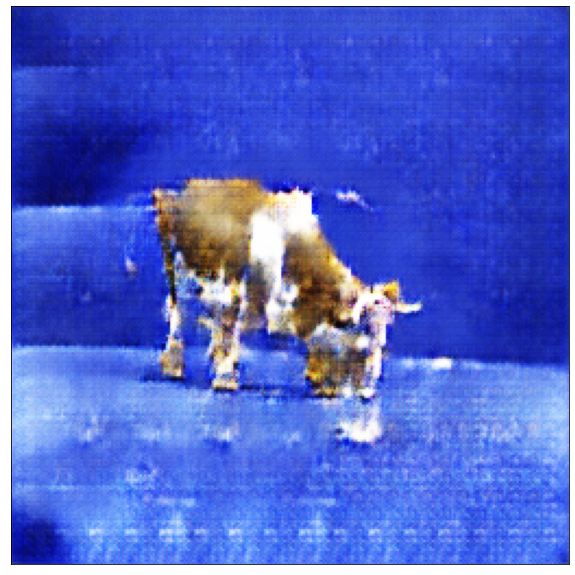

In [59]:
latent = 128
t_latent = torch.randn(1, latent, 1, 1, device=device)
modelcow=torch.load('model_cow30.pt')
t=modelcow(t_latent)
show_images(t)

good model: 12,20,22,24,25,27,30,31